# First looks can be deceiving


Hi there! Welcome back! This is part 4 of a series on Deep Learning for image classification. In the three previous installments we learnt about [imagenet and deep learning], [the train-test split], and trained a [first classifier] than can tell hotdogs from nothotdogs with near 90% accuracy. 


But wait! Now that I come to think of it, we have 120 hotdog images and 794 nohotdog images in our validation set, so a lazy classifier that assigns everything a 'nothotdog' label would get around 87% accuracy. Let's check if that's the case.

[imagenet and deep learning]: http://mateos.io/blog/getting-some-hotdogs/
[the train-test split]: http://mateos.io/blog/train-test-split/
[first classifier]: TODO link to third part of the series.

### Confusion matrix, precision and recall

The confusion matrix is a basic conceptual tool in binary classification. It's just a matrix such that rows represent true classes and columns represent predicted classes. 

Keras has assigned the label 0 to our hotdog class, which we consider positive, and 1 to our nothotdog class, which we consider negative. Therefore, in our binary classification setting we will have true positives top left, true negatives bottom right, false positives bottom left, and false negatives top right.

Therefore, precision will be

$$ precision = \frac{true\ positives}{predicted\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{1,0}} $$

and recall will be:

$$ recall = \frac{true\ positives}{total\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{0,1}}$$


In [5]:
%%time
validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary')

predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

predictions.shape

Found 888 images belonging to 2 classes.
CPU times: user 28 s, sys: 3.61 s, total: 31.6 s
Wall time: 7.27 s


0.7391304347826086 0.5964912280701754


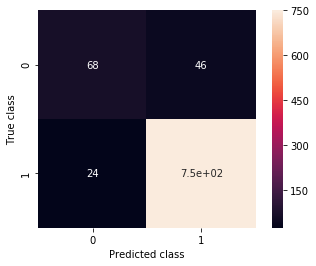

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Oh. Right. That means that only XXX% of our predicted hotdogs are such, and that we only detect around XXX% of all the hotdogs in the dataset. That is, when our users get a "hotdog" prediction, the probability that they are pointing at a hotdog will be around 80%. Not awful, but nothing to write home about either. However, the real problem is in the other metric, recall. That value means that when they point at a hotdog, the probability that the app recognizes it is only 20%! Not a great user experience. In short, our classifier is being way too cautious. It doesn't risk a "hotdog" prediction very often, and therefore it is not wrong very often. 

That illustrates a very important idea to keep in mind: choose the right metrics! Specially in unbalanced datasets, accuracy can be pretty misleading. We are fitting on binary cross entropy, which will naturally focus on getting right the most common class. In order to compensate for the fact that we have many more nothotdogs than hotdogs, `fit_generator` provides a `class_weight` parameter that allows us to artificially give more importance to underrepresented or specially important classes. Let's try it:

In [7]:
%%time
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=30,
                                     epochs=10,
                                     validation_data=validation_generator,
                                     validation_steps=10)

Epoch 1/10
30/30 [==============================] - 64s 2s/step - loss: 0.3818 - acc: 0.9008 - val_loss: 0.2301 - val_acc: 0.9211
Epoch 2/10
30/30 [==============================] - 70s 2s/step - loss: 0.3193 - acc: 0.9160 - val_loss: 0.2698 - val_acc: 0.8856
Epoch 3/10
30/30 [==============================] - 70s 2s/step - loss: 0.2949 - acc: 0.9196 - val_loss: 0.2844 - val_acc: 0.8887
Epoch 4/10
30/30 [==============================] - 67s 2s/step - loss: 0.2366 - acc: 0.9387 - val_loss: 0.2603 - val_acc: 0.8988
Epoch 5/10
30/30 [==============================] - 69s 2s/step - loss: 0.2380 - acc: 0.9388 - val_loss: 0.2466 - val_acc: 0.9211
Epoch 6/10
30/30 [==============================] - 69s 2s/step - loss: 0.2581 - acc: 0.9303 - val_loss: 0.3751 - val_acc: 0.8411
Epoch 7/10
30/30 [==============================] - 68s 2s/step - loss: 0.2019 - acc: 0.9451 - val_loss: 0.2823 - val_acc: 0.8998
Epoch 8/10
30/30 [==============================] - 75s 3s/step - loss: 0.1884 - acc: 0.95

This time the confusion matrix is this one:

0.6788990825688074 0.6491228070175439


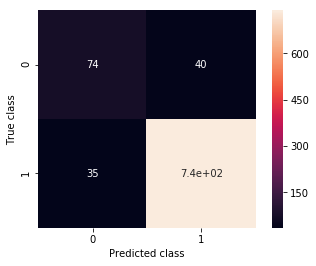

In [8]:
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Much better! This won't blow Jian-Yang away, but it's a a lot better, despite having worse accuracy. Consider that before this morning, you had no idea how to code a program to have some perception of the real world. Now you can!

Anyway, we have a classifier. It's not great, but I'm sure it can get better. Let's train it a bit more, shall we?

In [9]:
%%time
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history_pt2 = my_first_cnn.fit_generator(train_generator,
                                         class_weight = {0: 7, 1: 1},
                                         steps_per_epoch=30,
                                         epochs=20,
                                         validation_data=validation_generator,
                                         validation_steps=10,
                                         verbose=1)

Epoch 1/20
30/30 [==============================] - 71s 2s/step - loss: 0.1744 - acc: 0.9606 - val_loss: 0.2981 - val_acc: 0.8927
Epoch 2/20
30/30 [==============================] - 75s 3s/step - loss: 0.1609 - acc: 0.9558 - val_loss: 0.3125 - val_acc: 0.9190
Epoch 3/20
30/30 [==============================] - 68s 2s/step - loss: 0.1505 - acc: 0.9633 - val_loss: 0.3270 - val_acc: 0.8998
Epoch 4/20
30/30 [==============================] - 70s 2s/step - loss: 0.1040 - acc: 0.9733 - val_loss: 0.3085 - val_acc: 0.9140
Epoch 5/20
30/30 [==============================] - 71s 2s/step - loss: 0.0914 - acc: 0.9795 - val_loss: 0.2949 - val_acc: 0.9069
Epoch 6/20
30/30 [==============================] - 72s 2s/step - loss: 0.0894 - acc: 0.9810 - val_loss: 0.3209 - val_acc: 0.9038
Epoch 7/20
30/30 [==============================] - 66s 2s/step - loss: 0.0720 - acc: 0.9840 - val_loss: 0.3511 - val_acc: 0.8968
Epoch 8/20
30/30 [==============================] - 72s 2s/step - loss: 0.0840 - acc: 0.97

What's happening here? We are seeing a typical case of overfitting. Our training loss is improving really fast, but at the same time the validation loss increases in each epoc. The network is learning the specific details of the training set, which don't generalize all that well to the samples in the validation set. 

CPU times: user 140 ms, sys: 3.17 ms, total: 143 ms
Wall time: 93.3 ms


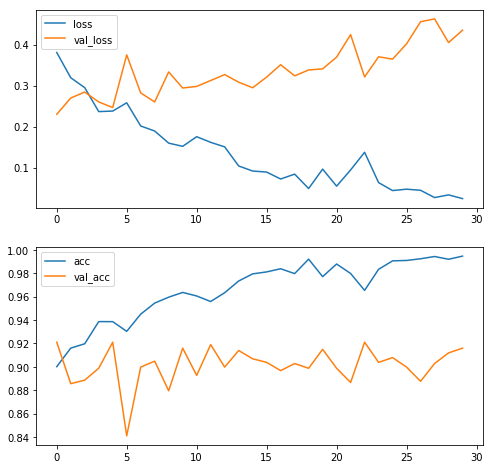

In [10]:
%%time
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

0.6697247706422018 0.6403508771929824
CPU times: user 34.3 s, sys: 5.31 s, total: 39.6 s
Wall time: 9.97 s


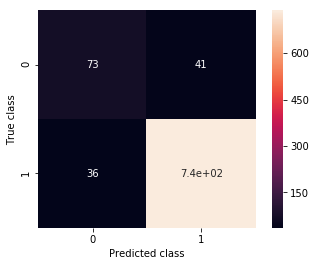

In [11]:
%%time
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

This is the tightrope act that we must make all the time when practising Machine Learning: the [bias-variance tradeoff]. In short, that refers to the trade-off between flexibility and generality of the models. A sufficiently flexible (read: complicated) model will always be able to learn non-relevant details of the input dataset (to overfit), and Neural Networks are nothing if not complicated: notice above where we built our simple CNN: it has over $10^6$ parameters! That's over a million knobs to tweak.

Overfitting means we have high variance: different samples will lead to very different estimations of the parameters. That will manifest as higher validation loss than training loss, as we see here from about epoch 8.

The solutions are simple but varied, and we need to keep many of them in our bag of tools for different occasions. Some are very general and some are pretty specific, but all of them fall under the heading of [regularization]. [This] is probably the best explanation of that that I've heard. In short, we want to penalize somehow the complexity of our models. That will in turn result in better generality.

In our specific example, image recognition, there's one very intuitive way to make our model recognize more varied images of hotdogs: to feed it more varied images of hotdogs. Since we already collected as many as we could, what we can do is to _generate_ more varied images of hotdogs. And that is exactly what we'll do in the next installment of this series.

[bias-variance tradeoff]: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
[regularization]: https://en.wikipedia.org/wiki/Regularization_(mathematics)#Generalization
[This]: https://www.coursera.org/lecture/machine-learning/regularization-and-bias-variance-4VDlf

### Further Reading

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python): A great introductory book by  François Chollet, author of Keras. Explains the practice first, then goes down to theory.

[Interview with François Chollet](https://www.pyimagesearch.com/2018/07/02/an-interview-with-francois-chollet/), author of DL with Python.

[Implementing a Neural Network from scratch with Python](https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8): An in depth view of the internal architecture of a NN, with a tutorial to implement backpropagation.

[Activation functions and their types](https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f): A nice discussion of activation functions.